In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import os, sys, time
# sys.path.append(os.path.expanduser('/ligo/home/craig.cahillane/Git/labutils/python_40mutils/'))
# import filterModuleStateExtractor
import numpy as np

import matplotlib as mpl 
import matplotlib.pyplot as plt 
# sys.path.append(os.path.expanduser('/ligo/home/craig.cahillane/utils/'))
# import plotHeader

import scipy.constants as scc
import scipy.special as scp

import subprocess
import nds2

%matplotlib inline

import ezca as ezca
ezca = ezca.Ezca()

# import awg

import scipy.signal as sig

import dtt2hdf

sys.path.append('/ligo/home/hang.yu/Desktop/pyComm/')
import pyctrl

makefit = True
if makefit:
    import iirrational.v1
    import iirrational.plots
    from iirrational.testing import iirrational_data
    from iirrational import TF_utilities

plotFigs = True
saveFigs = True
iterativeMethod = False

In [2]:
plt.style.use('bmh')

mpl.rcParams.update({'text.usetex': False,
#                      'text.color':'k',
#                      'lines.linewidth': 2,
                     'lines.markersize': 12, 
# #                      'font.size': 34, 
#                      'font.family': 'serif',
# #                      'font.serif': 'New Century Schoolbook',
                     'axes.grid': True,
#                      'axes.facecolor' :'w',
#                      'axes.labelcolor':'k',
                     'axes.titlesize': 20, 
                     'axes.labelsize': 20, 
#                      'xtick.color':'k',
                     'xtick.labelsize': 20, 
#                      'ytick.color':'k',
                     'ytick.labelsize': 20, 
#                      'grid.color': '#555555',
#                      'grid.alpha': 0.5,
                     'legend.fontsize': 20, 
#                      'legend.borderpad': 0.6,
#                      'figure.figsize': (16, 12),
#                      'figure.facecolor': 'w'
                    })

# MICH OLG Fitting

### Hueristic Tips:
If you aren't getting a fit which is anywhere close with iirrational
1) Alter the coherence cutoff "coh_cutoff".  This will change the data that iirrational sees.  Sometimes outliers affect iirrationals fitting routines a bit too much.
2) Add the SNR flag to the fit.  With every TF we compute an uncertainty based on the coherence of the measurement.  I generally don't include the SNR in the iirrational fits but it may be able to reduce the effect of low-SNR measurements.

In [3]:
# Read in xmls
MICH_OLTFxml ='/opt/rtcds/userapps/release/lsc/h1/scripts/feedforward/MICH_OLTF.xml'

MICH2DARMdict = dtt2hdf.read_diaggui(MICH_OLTFxml)

print MICH2DARMdict['results']['CSD'].keys()

['H1:LSC-DARM_IN1_DQ', 'H1:LSC-MICHFF_OUT', 'H1:LSC-MICH1_IN2', 'H1:LSC-MICH_OUT_DQ', 'H1:LSC-MICHFF_EXC', 'H1:LSC-MICH1_EXC', 'H1:LSC-MICH_IN1_DQ']


In [8]:
# In Lee's dtt2hdf extraction code, PSDs are actually ASDs
coh_cutoff = 0.95
ff_cutoff = 1.0 # Hz

MICHout = 'H1:LSC-MICH_OUT_DQ'
MICHFF = 'H1:LSC-MICHFF_OUT'
DARMerr = 'H1:LSC-DARM_IN1_DQ'

index = MICH2DARMdict['results']['COH'][MICHout]['channelB_inv'][DARMerr]
S2D_coh = MICH2DARMdict['results']['COH'][MICHout]['coherence'][index]
S2D_CSD = MICH2DARMdict['results']['CSD'][MICHout]['CSD'][index]
S2D_PSD = MICH2DARMdict['results']['PSD'][MICHout]['PSD'][0]**2
S2D_TF = S2D_CSD/S2D_PSD
print index
print S2D_coh


ff = MICH2DARMdict['results']['CSD']['H1:LSC-MICH_OUT_DQ']['FHz']

# Since we have the same frequency vectors, find the freq points where coherence is > than the cutoff for both
#goodCoh = np.intersect1d(np.argwhere(S2D_coh > coh_cutoff)[:,0], np.argwhere(SFF2D_coh > coh_cutoff)[:,0])
goodCoh = np.intersect1d(goodCoh, np.argwhere(ff > ff_cutoff))

S2D_goodCoh = S2D_coh[goodCoh]
S2D_goodCSD = S2D_CSD[goodCoh]
S2D_goodPSD = S2D_PSD[goodCoh]
S2D_goodTF = S2D_goodCSD/S2D_goodPSD



goodff = ff[goodCoh]

print 'Number of points with coherence above {}: {}'.format(coh_cutoff, len(goodCoh))

3
[0.9777164  0.9551939  0.96020406 ... 0.05747895 0.02351843 0.66541606]


NameError: name 'SFF2D_coh' is not defined

In [4]:
MICH_out = 'H1:LSC-MICH_IN1_DQ'
MICH_in = 'H1:LSC-MICH1_IN2'

MICHindex = MICH2DARMdict['results']['COH'][MICH_in]['channelB_inv'][MICH_out]
MICH_coh = MICH2DARMdict['results']['COH'][MICH_in]['coherence'][MICHindex]
MICH_CSD = MICH2DARMdict['results']['CSD'][MICH_in]['CSD'][MICHindex]
MICH_PSD = MICH2DARMdict['results']['PSD'][MICH_in]['PSD'][0]**2
MICH_OLTF = MICH_CSD/MICH_PSD

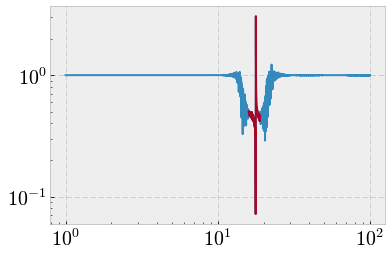

In [14]:
plt.loglog(ff, np.abs(MICH_OLTF))
start = 16
end = 19
respeak_loc = np.intersect1d(np.argwhere(ff > start)[:,0], np.argwhere(ff < end)[:,0])
freq_res = ff[respeak_loc]
MICH_OLTF_rp = MICH_OLTF[respeak_loc]
plt.loglog(freq_res,np.abs(MICH_OLTF_rp))

In [32]:
if not iterativeMethod:
    # Do the iirrational fitting
    f_nyq = 2**22 #just make huge
    print f_nyq
    fit=iirrational.v1.data2filter(
        data=MICH_OLTF_rp, 
        F_Hz=freq_res, 
       order_initial=4, 
#         SNR=goodCoh * np.abs(1./goodff), 
        F_nyquist_Hz=f_nyq, 
        hints={'log_print':True}
    )

4194304
(direct = 7.026e-01, Psvd= 7.026e-01, Zsvd= 7.026e-01)
LINEAR Final Residuals:  0.33089946528516295
Initial Order: (Z= 4, P= 4, Z-P= 0)
TRIPLETS (rat = 0.0425647399154, pre = 0.0787714515757, mid = 0.0787714515754, post = 0.00334409765616
RATIO:  1.5324960110285337
fit NOT improved from pair at 17.7788075129543
FINAL RESIDUALS 0.07856494161524924


Zeros: [-0.00752391+17.75509284j -0.00752391-17.75509284j]
Poles: [-0.00370128+17.80253611j -0.00370128-17.80253611j]
Gain: [0.45962483+7.76806771e-17j]


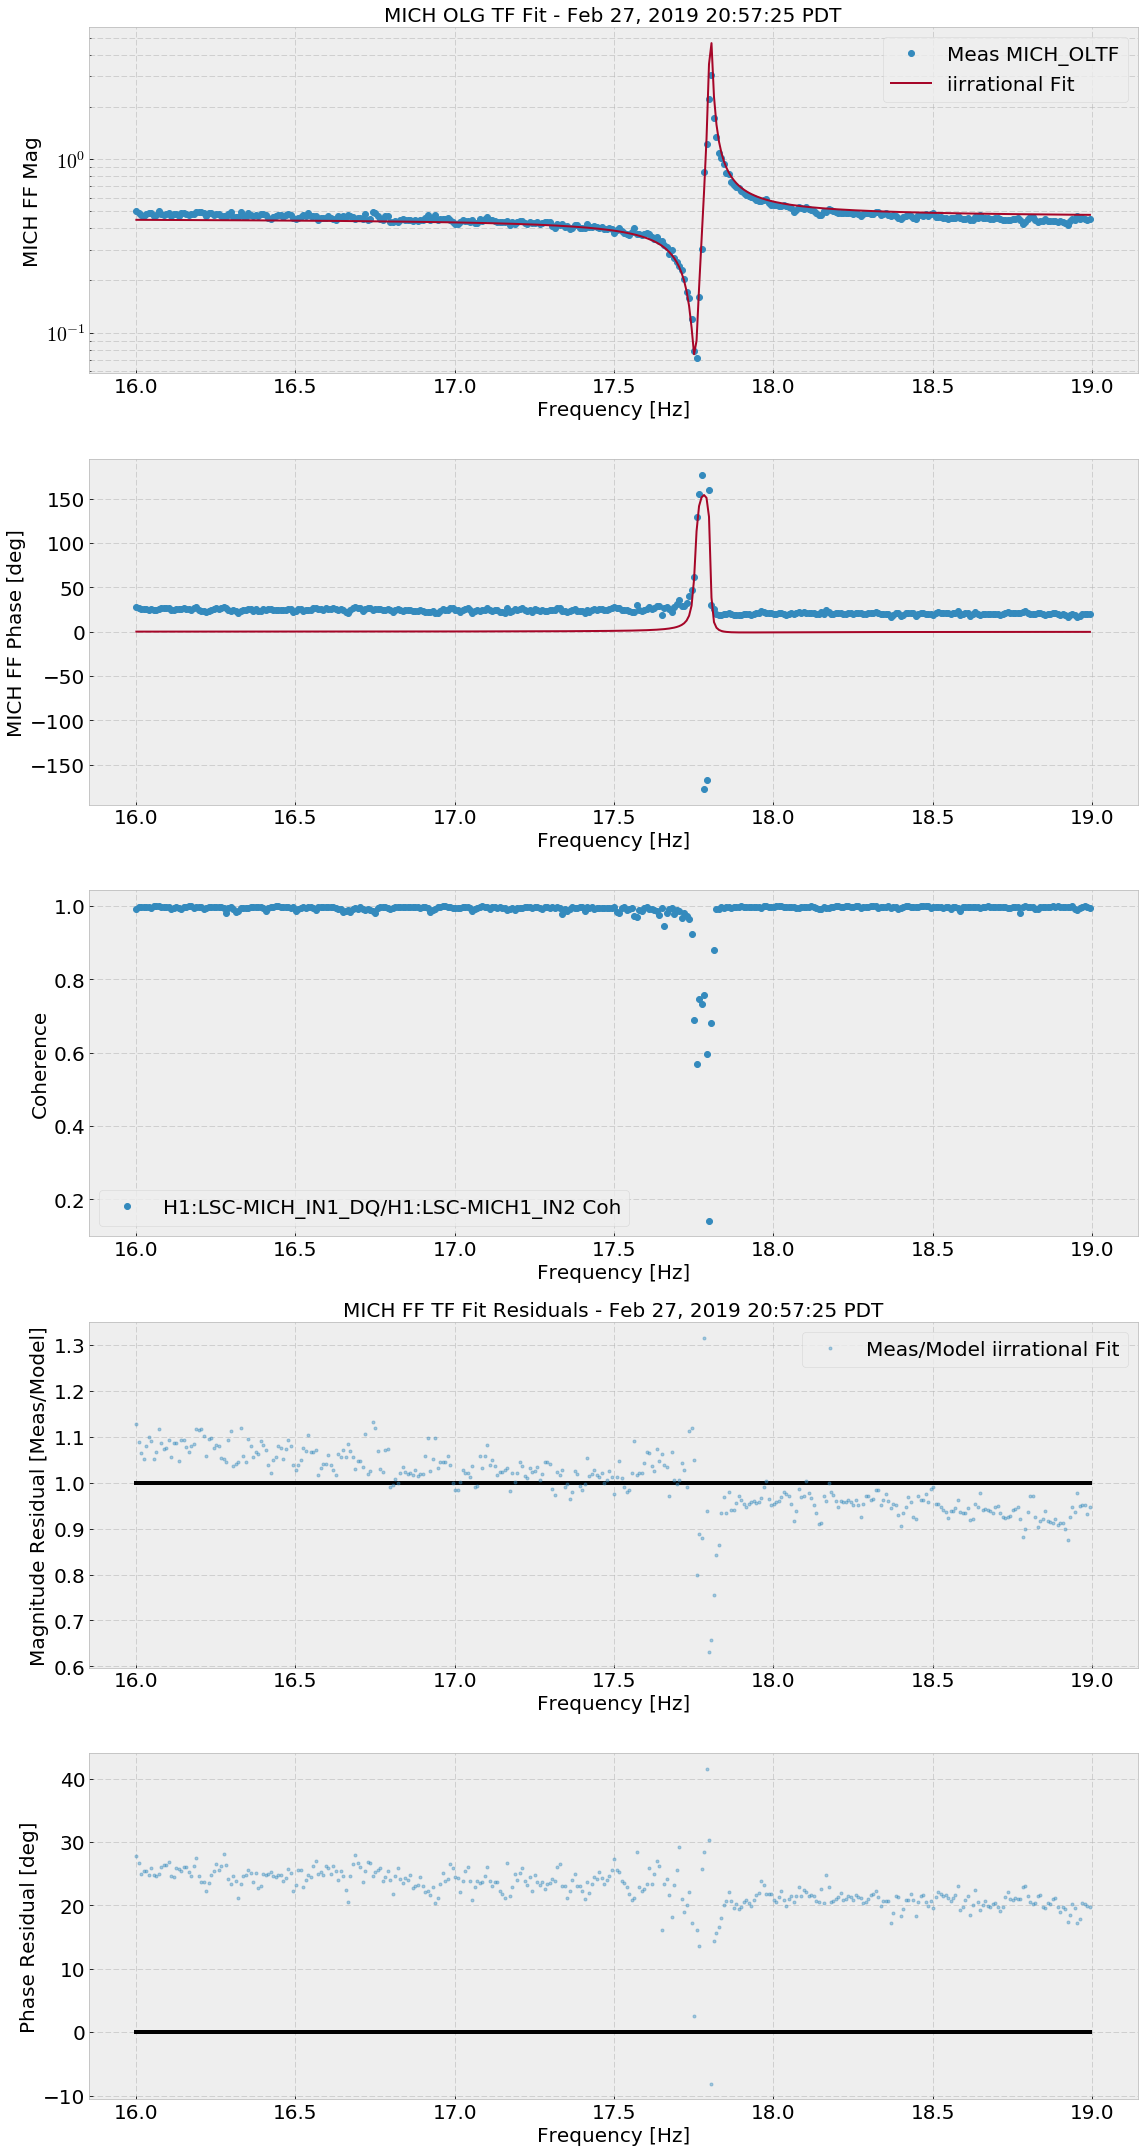

In [47]:
if not iterativeMethod:
    zpk_s = pyctrl.d2c(zpk_z=fit.fitter.ZPK, fs=2.*f_nyq, method='matched', f_match=0.1)
    zz, pp, kk = zpk_s

    print 'Zeros: {}'.format(zz/(2*np.pi))
    print 'Poles: {}'.format(pp/(2*np.pi))
    print 'Gain: {}'.format(kk)

    # Use Hang's useful tools for discarding overfitting from iirrational
#     zpk_s2 = pyctrl.discard_similar_pz(zpk_s) # remove p and z that are close in frequency
#     zz, pp, kk = zpk_s
#     rolloff_freq = 200.0 # Hz
#     rolloff_Q = 5
#     a, b = pyctrl.get_res_g_pole_pair(rolloff_freq, 1)

#     rolloff_poles = np.array([a + 1j*b, a - 1j*b])
#     extrazero = -2*np.pi*0.5
#     extrapole = -2*np.pi*5.0
#     extragain = 10.0
    
    
    zzr = [-4.265795e-02+1j*1.115733e+02, -4.265795e-02-1j*1.115733e+02]
    ppr = [-1.885655e-02+1j*1.118518e+02, -1.885655e-02-1j*1.118518e+02]
    kkr = 3.361844e-01
#    zzr = [-0.00678922+17.75743854*1j -0.00678922-17.75743854*1j,2.77271631 +8.174590021*1j  2.77271631 -8.17459002*1j]
#    ppr = [-0.00124465+11.01626438*1j -0.00124465-11.01626438*1j -0.00300111+17.80176729*1j -0.00300111-17.80176729*1j]
#    kkr =  [0.33618442-2.25063609e-15*1j]
    zpk_r = zzr, ppr, kkr

#     zza = np.append(zz, AC_zeros)
#    ppa = np.append(pp, AC_poles )
#     kka = kk 
#    zpk_a = zza, ppa, kka 
#    print
#    print 'Rest Zeros: {}'.format(zzr/(2*np.pi))
#     print 'Rest Poles: {}'.format(ppr/(2*np.pi))
#     print 'Rest Gain: {}'.format(kkr)

    __, MICH_OLTF_fit=sig.freqresp((zz, pp, kk), 2.*np.pi*freq_res)
    __, MICH_OLTF_handfit = sig.freqresp((zzr, ppr, kkr), 2.*np.pi*freq_res)
#    __, FFTFfitr=sig.freqresp((zzr, ppr, kkr), 2.*np.pi*ff)
#    __, FFTFfit_goodff=sig.freqresp((zz, pp, kk), 2.*np.pi*goodff)
#    __, FFTFfitr_goodff=sig.freqresp((zzr, ppr, kkr), 2.*np.pi*goodff)
#     __, FFTFfita=sig.freqresp((zza, ppa, kka), 2.*np.pi*ff)
#     __, FFTFfitl=sig.freqresp(zpk_l, 2.*np.pi*ff)
#     __, FFTFfit2=sig.freqresp(zpk_2, 2.*np.pi*ff)

    if plotFigs:
        fig = plt.figure(figsize=(16,30))
        s1 = fig.add_subplot(511)
        s2 = fig.add_subplot(512)
        s3 = fig.add_subplot(513)
        s4 = fig.add_subplot(514)
        s5 = fig.add_subplot(515)

        s1.semilogy(freq_res, np.abs(MICH_OLTF_rp), '.', label='Meas MICH_OLTF')
        s1.semilogy(freq_res, np.abs(MICH_OLTF_fit), label='iirrational Fit')
       # s1.semilogy(freq_res, np.abs(MICH_OLTF_handfit),'+', label='hand fit')
        # s1.loglog(ff, np.abs(FFTFfitr), ls='--', 
#                  label='modified fit')
#         s1.loglog(ff, np.abs(FFTFfita), ls='--', 
#                   label='modified fit + AC filt + {} Hz rolloff'.format(rolloff_freq))
#         s1.loglog(ff, np.abs(FFTFfita), ls='--', 
#                   label='modified fit fit'.format(rolloff_freq))

        s2.plot(freq_res, 180/np.pi*np.angle(MICH_OLTF_rp), '.')
        s2.plot(freq_res, 180/np.pi*np.angle(MICH_OLTF_fit))
#         s2.plot(freq_res, 180/np.pi*np.angle(MICH_OLTF_handfit), '+')
#         s2.semilogx(ff, 180/np.pi*np.angle(FFTFfitr), ls='--')
#         s2.semilogx(ff, 180/np.pi*np.angle(FFTFfita), ls='--')
#         s2.semilogx(ff, 180/np.pi*np.angle(FFTFfitl), ls='--')

        s3.plot(freq_res, MICH_coh[respeak_loc], '.', label='H1:LSC-MICH_IN1_DQ/H1:LSC-MICH1_IN2 Coh')
#         s3.semilogx(goodff, S2D_goodCoh, color='red', label='DARM/MICHout Coh')

        ### RESIDUALS ###
        s4.plot([freq_res[0], freq_res[-1]], [1,1], color='k', lw=4)
        s4.plot(freq_res, np.abs(MICH_OLTF_rp/MICH_OLTF_fit), '.', markersize=6, alpha=0.4, label='Meas/Model iirrational Fit')
        #s4.plot(freq_res, np.abs(MICH_OLTF_rp/MICH_OLTF_handfit), '.', markersize=6, alpha=0.4, label='Meas/Hand Fit')
#         s4.semilogx(goodff, np.abs(FFTF/FFTFfitr_goodff), '.', label='Meas/Model modified Fit')

        s5.plot([freq_res[0], freq_res[-1]], [0,0], color='k', lw=4)
        s5.plot(freq_res, 180/np.pi*np.angle(MICH_OLTF_rp/MICH_OLTF_fit), '.', markersize=6, alpha=0.4)
#         s5.semilogx(goodff, 180/np.pi*np.angle(FFTF/FFTFfitr_goodff), '.')
        
#         s1.set_xlim([ff[1], ff[-1]])
#         s2.set_xlim([ff[1], ff[-1]])
#         s3.set_xlim([ff[1], ff[-1]])
#         s4.set_xlim([ff[1], ff[-1]])
#         s5.set_xlim([ff[1], ff[-1]])

#         s1.set_xlim([3, 300])
#         s2.set_xlim([3, 300])
#         s3.set_xlim([3, 300])

#        s1.set_ylim([3e-3, 1e2])
#        s2.set_yticks([-180,-90,0,90,180])
#         s4.set_ylim([0.95, 1.05])
#         s5.set_ylim([-30, 30])

        s1.set_title('MICH OLG TF Fit - {}'.format(time.strftime('%b %d, %Y %H:%M:%S PDT')))
        s1.set_ylabel('MICH FF Mag')
        s2.set_ylabel('MICH FF Phase [deg]')
        s3.set_ylabel('Coherence')
        
        s4.set_title('MICH FF TF Fit Residuals - {}'.format(time.strftime('%b %d, %Y %H:%M:%S PDT')))
        s4.set_ylabel('Magnitude Residual [Meas/Model]')
        s5.set_ylabel('Phase Residual [deg]')
        
        s1.set_xlabel('Frequency [Hz]')
        s2.set_xlabel('Frequency [Hz]')
        s3.set_xlabel('Frequency [Hz]')
        s4.set_xlabel('Frequency [Hz]')
        s5.set_xlabel('Frequency [Hz]')
        
        s1.legend()
        s3.legend()
        s4.legend()

        s1.grid(which='minor', ls='--')
        s2.grid(which='minor', ls='--')
        s3.grid(which='minor', ls='--')
        s4.grid(which='minor', ls='--')
        s5.grid(which='minor', ls='--')
        
        plt.tight_layout()
        if True:
            # Save plot and ZPK associated with fit, as well as MICH OLTF data
            tempTime = time.strftime('%Y%m%d_%H%M%S')
            saveTxt1 = np.vstack((ff, np.abs(MICH_OLTF), np.angle(MICH_OLTF))).T
            np.savetxt('/opt/rtcds/userapps/release/lsc/h1/scripts/feedforward/data/{}_MICH_OLTF_data.txt'.format(tempTime), saveTxt1,
                       header='Freq [Hz], Mag [relative], Phase [rads]')
            np.savetxt('/opt/rtcds/userapps/release/lsc/h1/scripts/feedforward/data/{}_MICH_OLTF_iirationalFit_zeros.txt'.format(tempTime), zz, 
                       header='iirational zpk fit to MICH OLTF data: Zeros [rads], Poles [rads], Gain={}'.format(kk))
            np.savetxt('/opt/rtcds/userapps/release/lsc/h1/scripts/feedforward/data/{}_MICH_OLTF_iirationalFit_poles.txt'.format(tempTime), pp, 
                       header='iirational zpk fit to MICH OLTF data: Zeros [rads], Poles [rads], Gain={}'.format(kk))

            plt.savefig('/opt/rtcds/userapps/release/lsc/h1/scripts/feedforward/plots/{}_MICH_OLTF_iirrationalFit.png'.format(time.strftime('%Y%m%d_%H%M%S')), bbox_inches='tight')
        plt.show()


In [29]:
print '##############'
print 'VERY IMPORTANT'
print '##############'
print 'Make sure you are using correct filter fit!  Use Bode Plot in foton to ensure your fit looks like plots 1 and 2 above!'
print
if not iterativeMethod:
    print pyctrl.get_foton(zpk_s) # use iirrational fit
#     print pyctrl.get_foton(zpk_r) # use modified fit
print
print '########'
print 'HAND FIT'
print '########'
print pyctrl.get_foton(zpk_r)

##############
VERY IMPORTANT
##############
Make sure you are using correct filter fit!  Use Bode Plot in foton to ensure your fit looks like plots 1 and 2 above!

zpk(
[
-4.265795e-02+i*1.115733e+02; 
-4.265795e-02-i*1.115733e+02; 
1.742149e+01+i*5.136246e+01; 
1.742149e+01-i*5.136246e+01; 
],
[
-7.820361e-03+i*6.921723e+01; 
-7.820361e-03-i*6.921723e+01; 
-1.885655e-02+i*1.118518e+02; 
-1.885655e-02-i*1.118518e+02; 
],
3.361844e-01
)
None

########
HAND FIT
########
zpk(
[
-4.265795e-02+i*1.115733e+02; 
-4.265795e-02-i*1.115733e+02; 
1.742149e+01+i*5.136246e+01; 
1.742149e+01-i*5.136246e+01; 
],
[
-7.820361e-03+i*6.921723e+01; 
-7.820361e-03-i*6.921723e+01; 
-1.885655e-02+i*1.118518e+02; 
-1.885655e-02-i*1.118518e+02; 
],
3.361844e-01
)
None


### Iterative Method
So we've got $-\dfrac{\frac{DARMIN}{MICH}}{\frac{DARMIN}{MICHFF}}$ fit from above.  Now we just read in the current FF settings $\alpha$ from the FM to compute to new additional FF $\beta$

In [14]:
def tconvert(t):
    return int(subprocess.check_output(['tconvert', t]))

Foton dictionary lookup table already exists at /ligo/home/craig.cahillane/fotonLookupTable.dict

Failed to retrieve filter module named LSC-MICHFF on nds.ligo-wa.caltech.edu
Trying h1nds1...
Variable "conn" was not defined
No FMs active for LSC-MICHFF, TF = 1 for all frequencies


/ligo/cds/lho/h1/anaconda/anaconda2/envs/cragenv/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))
/ligo/cds/lho/h1/anaconda/anaconda2/envs/cragenv/lib/python2.7/site-packages/matplotlib/axes/_base.py:3179: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


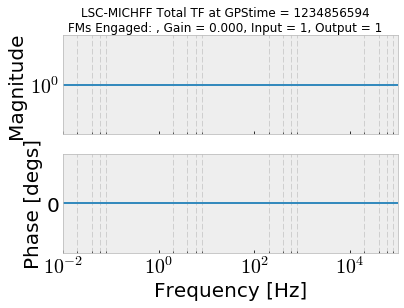

In [15]:
gpstime = tconvert('now-3mins')
FMs = np.array(['LSC-MICHFF'])
FMTFs, FMdict, fotonDict, args = filterModuleStateExtractor.getFMState(['LSC-MICHFF'], gpstime)

In [16]:
# FMdict[FMs[0]]

In [17]:
FMsActivated = np.array([])
for key in FMdict[FMs[0]]['ONOFF'].keys():
    if 'FM' in key and FMdict[FMs[0]]['ONOFF'][key] == '1':
        FMsActivated = np.append(FMsActivated, key)
print FMsActivated

[]


In [18]:
fs = fotonDict[FMs[0]]['fs']
wwNorm = 2 * np.pi * goodff / fs
wwNormfull = 2 * np.pi * ff / fs

alphaTF = np.array([])
alphaTFfull = np.array([])
for activatedFM in FMsActivated:
    key = int(activatedFM[-1])-1
    sos = fotonDict[FMs[0]][key]['sosCoeffs']
    ww, TF = sig.sosfreqz(sos, worN=wwNorm)
    ww, TFfull = sig.sosfreqz(sos, worN=wwNormfull)
    
    if 'Vio' not in fotonDict[FMs[0]][key]['name']:
        if len(alphaTF) == 0:
            alphaTF = np.copy(TF)
            alphaTFfull = np.copy(TFfull)
        else:
            alphaTF *= TF
            alphaTFfull *= TFfull

ValueError: x and y must have same first dimension, but have shapes (1506,) and (0,)

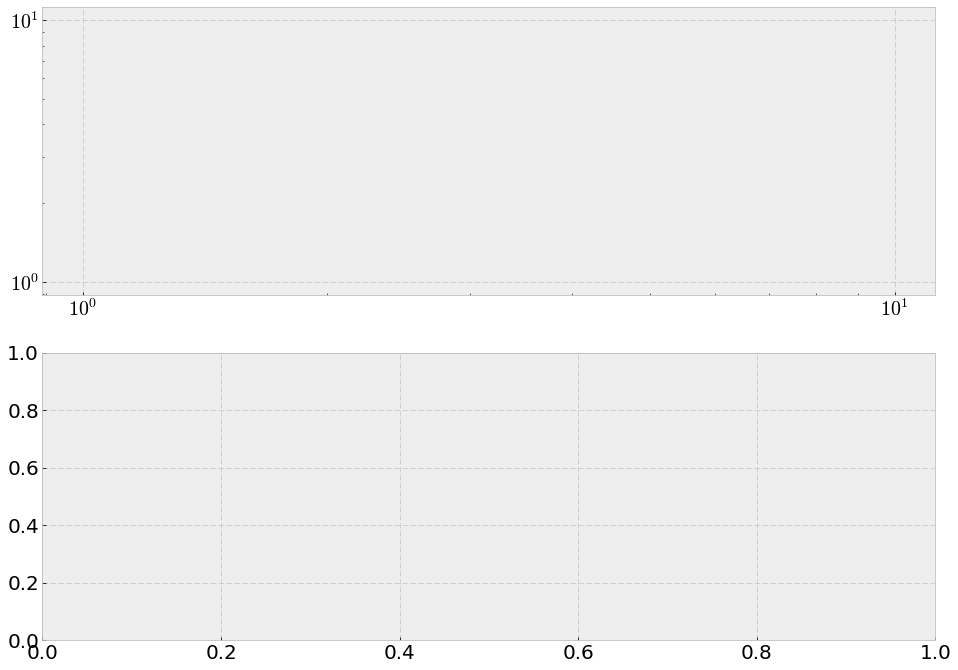

In [19]:
fig = plt.figure(figsize=(16,18))
s1 = fig.add_subplot(311)
s2 = fig.add_subplot(312)

s1.loglog(goodff, np.abs(alphaTF), '.')
s1.loglog(ff, np.abs(alphaTFfull))

s2.semilogx(goodff, 180/np.pi*np.angle(alphaTF), '.')
s2.semilogx(ff, 180/np.pi*np.angle(alphaTFfull), '.')

s1.set_title('$\\alpha$ FF TF')

# s1.set_xlim([5,300])
# s2.set_xlim([5,300])
s1.set_ylim([1e-2,3])
s2.set_yticks([-180,-90,0,90,180])

s1.grid(which='minor', ls='--')
s2.grid(which='minor', ls='--')
plt.show()

In [ ]:
betaTF = 1 - S2D_goodTF / (SFF2D_goodTF * alphaTF)

In [ ]:
# Do the iirrational fitting
f_nyq = 2**21 #just make huge
print f_nyq
fit=iirrational.v1.data2filter(
    data=betaTF, 
    F_Hz=goodff, 
#     order_initial=20, 
#     SNR=goodCoh * np.abs(1./goodff), 
    F_nyquist_Hz=f_nyq, 
    hints={'log_print':True}
)


In [ ]:
zpk_b = pyctrl.d2c(zpk_z=fit.fitter.ZPK, fs=2.*f_nyq, method='matched', f_match=0.1)
zze, ppe, kke = zpk_b

print 'Zeros: {}'.format(zze/(2*np.pi))
print 'Poles: {}'.format(ppe/(2*np.pi))
print 'Gain: {}'.format(kke)

zz = zze[1:]
pp = ppe[1:]
kk = kke #* zze[0]/ppe[0]

zpk_final = (zz, pp, kk)
# Use Hang's useful tools for discarding overfitting from iirrational
# zpk_s2 = pyctrl.discard_similar_pz(zpk_s) # remove p and z that are close in frequency

__, betaTFfit=sig.freqresp((zz, pp, kk), 2.*np.pi*ff)
__, betaTFfite=sig.freqresp((zze, ppe, kke), 2.*np.pi*ff)

if plotFigs:
    fig = plt.figure(figsize=(16,18))
    s1 = fig.add_subplot(311)
    s2 = fig.add_subplot(312)
    s3 = fig.add_subplot(313)

    s1.loglog(goodff, np.abs(betaTF), '.', label='Meas betaTF')
    s1.loglog(ff, np.abs(betaTFfit), label='fit by hand')
    s1.loglog(ff, np.abs(betaTFfite), ls='--', label='native iirrational Fit')

    
    s2.semilogx(goodff, 180/np.pi*np.angle(betaTF), '.')
    s2.semilogx(ff, 180/np.pi*np.angle(betaTFfit))
    s2.semilogx(ff, 180/np.pi*np.angle(betaTFfite), ls='--')
    
    s3.semilogx(goodff, SFF2D_goodCoh, label='DARM/MICHFF Coh')
    s3.semilogx(goodff, S2D_goodCoh, color='red', label='DARM/MICHout Coh')
    
    lowF = 10
    highF = 50
    s1.set_xlim([lowF, highF])
    s2.set_xlim([lowF, highF])
    s3.set_xlim([lowF, highF])
    
    s1.set_ylim([1e-2, 3])
    s2.set_yticks([-180,-90,0,90,180])
    
    s1.set_title('MICH Iterative TF Fit - {}'.format(time.strftime('%b %d, %Y %H:%M:%S PDT')))
    s1.set_ylabel('MICH betaTF Mag')
    s2.set_ylabel('MICH betaTF Phase [deg]')
    s3.set_ylabel('Coherence')
    
    s3.set_xlabel('Frequency [Hz]')
    s1.legend()
    
    s1.grid(which='minor', ls='--')
    s2.grid(which='minor', ls='--')
    s3.grid(which='minor', ls='--')
    if False:
        # Save plot and ZPK associated with fit, as well as FFTF data
        tempTime = time.strftime('%Y%m%d_%H%M%S')
        saveTxt1 = np.vstack((goodff, np.abs(FFTF), np.angle(FFTF))).T
        np.savetxt('./data/{}_MICH_Iterative_TF_data.txt'.format(tempTime), saveTxt1,
                   header='Freq [Hz], Mag [relative], Phase [rads]')
        np.savetxt('./data/{}_MICH_Iterative_TF_iirationalFit_zeros.txt'.format(tempTime), zz, 
                   header='iirational zpk fit to betaTF data: Zeros [rads], Poles [rads], Gain={}'.format(kk))
        np.savetxt('./data/{}_MICH_Iterative_TF_iirationalFit_poles.txt'.format(tempTime), pp, 
                   header='iirational zpk fit to betaTF data: Zeros [rads], Poles [rads], Gain={}'.format(kk))
        
        plt.savefig('./plots/{}_MICH_Iterative_iirrationalFit.pdf'.format(time.strftime('%Y%m%d_%H%M%S')),
                    bbox_inches='tight')
    plt.show()
index = np.argwhere(goodff>30)[0][0]
print goodff[index]
print np.abs(FFTF[index])
print 180/np.pi*np.angle(FFTF[index])

In [ ]:
print pyctrl.get_foton(zpk_final)